In [1]:
# !pip install --upgrade datasets==3.6.0 && pip install librosa torch matplotlib transformers
# !git clone https://github.com/abdozawia20/Speech-To-Speech-Model.git
# %cd Speech-To-Speech-Model

In [4]:
ls

sample_data/


In [14]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from dataset_loader import *
from encoders import *
from models.ASR_MT_TTS.model import * 
from torch.utils.data import DataLoader
from IPython.display import Audio, display
import numpy as np
import torch
import torch.nn as nn
import os
import sys # Required for sys.getsizeof
import librosa.display
import matplotlib.pyplot as plt
import random # only used for picking random records from the dataset


In [ ]:
#@title Loading the dataset

dataset = load_train_data()
english_dataset = dataset['ar']

random_seed = random.randint(0, 1_000_000)
shuffled_english_dataset = english_dataset.shuffle(seed=random_seed)
english_audio_record = next(iter(shuffled_english_dataset))

audio_array = np.array(english_audio_record['audio']['array'])
sampling_rate = english_audio_record['audio']['sampling_rate']

play_audio(english_audio_record)

Spectrogram shape: (1025, 282)
Spectogram Object: [-79.20935372 -69.37756934 -72.0672667  -80.         -77.96008462
 -80.         -71.2215069  -69.78991972 -69.72620939 -72.09660673]


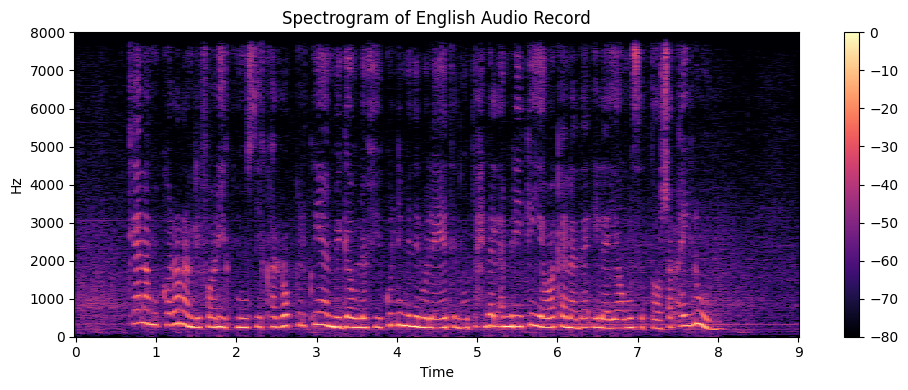

In [ ]:
#@title Spectogram Usage

# Example usage with the previously loaded english_audio_record
spectrogram = SpectogramEncoder(audio_array, sampling_rate)

print("Spectrogram shape:", spectrogram.shape)
print("Spectogram Object:", spectrogram[1][:10])

# Optionally, display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spectrogram of English Audio Record')
plt.tight_layout()
plt.show()

Using the pretrained model "Wav2Vec 2.0" developed by Facebook/Meta. This model has already been trained on thousands of hours of speech and knows how to extract rich feature vectors from waveforms.

In [ ]:
#@title Wav2Vec Usage
# 1. Instantiate the pretrained model
feature_encoder = Wav2VecEncoder(model_name="facebook/wav2vec2-base-960h")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_encoder.to(device)

try:
    # 2. Get the audio data
    # FIX: We wrap this in np.array() to ensure it is not a list
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']

    # --- RESAMPLING ---
    target_sampling_rate = 16000

    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocessing
    inputs = feature_encoder.processor(audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.to(device)

    # 4. Generate the Vectors
    with torch.no_grad():
        generated_vectors = feature_encoder(input_values)

    # 5. Inspect the Output
    print(f"\nOriginal Audio Shape (Resampled): {audio_input.shape}")
    print(f"Generated Vector Shape: {generated_vectors.shape} (Batch, Latent_Time, Features)")

    print("\nThese are the Pretrained Wav2Vec latent representations.")
    print("First 10 features of the first time step:")
    print(generated_vectors[0, 0, :10])

except Exception as e:
    print(f"An error occurred: {e}")
    # This helps us debug if it happens again
    import traceback
    traceback.print_exc()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original Audio Shape (Resampled): (144000,)
Generated Vector Shape: torch.Size([1, 449, 768]) (Batch, Latent_Time, Features)

These are the Pretrained Wav2Vec latent representations.
First 10 features of the first time step:
tensor([-0.0407, -0.0086, -0.0202, -0.0791, -0.1076, -0.1127,  0.0591, -0.0412,
         0.0570, -0.2091], device='cuda:0')


Using the pretrained model Vector Quantized Generative Adversarial Network "VQ-GAN"(known as EnCodec) developed by Meta. Uses Vector Quantization to compress Input Audio Waveform(the audio file / the speech signal).

In [ ]:
#@title VQ-GAN Usage
# 1. Instantiate the VQ-GAN (EnCodec)
vqgan_model = VQGANEncoder(model_name="facebook/encodec_24khz")
vqgan_model.to(device)

try:
    # 2. Prepare Data (EnCodec expects 24kHz)
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']
    target_sampling_rate = 24000

    # Resample
    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling for VQ-GAN from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocess (Add Batch and Channel dimensions)
    # EnCodec expects: (Batch, Channels, Time) -> (1, 1, Time)
    inputs = vqgan_model.processor(raw_audio=audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs["input_values"].to(device)

    # 4. ENCODE: Audio -> Discrete Codes
    # This is the "VQ" part. We get a list of integers.
    with torch.no_grad():
        # Change 'bandwidth' here to: 1.5, 3.0, 6.0, 12.0, or 24.0. The greater the bandwidth, the better the audio output but more latent codes generated.
        # As the sequence of numbers becomes too long and complex, and the "Bridge" translation model will struggle to learn it later.
        # For example, At 1.5 kbps: For every time step, the bridge only needs to predict 2 numbers. At 24.0 kbps: For every time step, the bridge must predict 32 numbers
        encoder_outputs = vqgan_model.encode(input_values, bandwidth=6.0)
        audio_codes = encoder_outputs.audio_codes
        audio_scales = encoder_outputs.audio_scales

    # 5. DECODE: Discrete Codes -> Audio
    # This is the "GAN" part (Generator). It reconstructs sound from the numbers.
    with torch.no_grad():
        reconstructed_audio = vqgan_model.decode(audio_codes, audio_scales)

    # 6. Inspect Results
    print(f"\nOriginal Audio Shape: {input_values.shape}")
    print(f"Compressed Codes Shape: {audio_codes.shape} (Batch, Codebooks, Time_Frames)")

    print("\nThese are the Discrete Codes (The 'Language' of the Audio):")
    # We look at the first codebook, first 10 time steps
    print(audio_codes[0, 0, :20])

    # 7. Listen to the Result
    # If the VQ-GAN is working, this should sound almost identical to the original.
    print("\nPlaying Reconstructed Audio (Decoded from codes):")
    display(Audio(data=reconstructed_audio.cpu().numpy().squeeze(), rate=target_sampling_rate))

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Resampling for VQ-GAN from 16000Hz to 24000Hz...

Original Audio Shape: torch.Size([1, 1, 216000])
Compressed Codes Shape: torch.Size([1, 1, 8, 675]) (Batch, Codebooks, Time_Frames)

These are the Discrete Codes (The 'Language' of the Audio):
tensor([[ 780,  499,  887,  ...,  472,  472,  475],
        [ 424,  430,  896,  ...,  743,  700,  424],
        [ 678,  880,  829,  ..., 1015,  675,  982],
        ...,
        [ 881,  710,  478,  ...,  505,   19,  494],
        [1002,   49,  550,  ...,  983,  772,  772],
        [ 899,  647,  979,  ...,  931, 1012,  899]], device='cuda:0')

Playing Reconstructed Audio (Decoded from codes):


In [ ]:
stt_model = STTEngine(engine="whisper", model_size="small", language="ar")
transcription = stt_model.transcribe(audio_array, sampling_rate)
print(transcription)

Switching STT Engine to: whisper in the (ar) language...
Loading WhisperModel (small) on cuda...
Transcribing audio file (Whisper)...
Detected language: ar
Language probability: 1
----------------------------------------
[0.00 → 9.00]  كان مكرراً لفاريق موسيقه الرق الكيان بجولة في كل من الولايات المتحدة الأمريكية وكندا إلى يوم 16 أيلون
 كان مكرراً لفاريق موسيقه الرق الكيان بجولة في كل من الولايات المتحدة الأمريكية وكندا إلى يوم 16 أيلون 


In [ ]:
tts_model = TTSEngine(engine="piper", model_size="medium", language="ar")
audio = tts_model.run_inference(transcription)
play_audio(audio)

Switching TTS Engine to: piper...
Piper binary found.
Loading voice model: medium...
Model files for https://huggingface.co/rhasspy/piper-voices/resolve/main/ar/ar_JO/kareem/medium/ar_JO-kareem-medium.onnx already exist.
Voice model 'https://huggingface.co/rhasspy/piper-voices/resolve/main/ar/ar_JO/kareem/medium/ar_JO-kareem-medium.onnx' ready.
Generating audio for the following text (Piper): 
 ' كان مكرراً لفاريق موسيقه الرق الكيان بجولة في كل من الولايات المتحدة الأمريكية وكندا إلى يوم 16 أيلون '


In [ ]:
# TEST: SpeechBaseline Model Verification
from model import SpeechBaseline
from dataset_loader import load_train_data
import numpy as np
from IPython.display import Audio, display

print("Loading SpeechBaseline...")
baseline = SpeechBaseline()

print("Loading one sample from dataset...")
# Note: ensure dataset_loader selects the working dataset (fleurs)
datasets = load_train_data()
ds_en = datasets["en"]
sample = next(iter(ds_en))

audio_data = sample['audio']['array']
sampling_rate = sample['audio']['sampling_rate']

print("Original Audio:")
display(Audio(audio_data, rate=sampling_rate))

print("Running Inference (En -> En)...")
output = baseline.predict(audio_data, sampling_rate)

print("Generated Audio:")
# SpeechT5 output is typically 16kHz
display(Audio(output, rate=16000))


In [ ]:
main ipynb:
# UNet Spectrogram Translator Test
import torch
import matplotlib.pyplot as plt
import numpy as np
from unet import UNetSpectrogramTranslator

print("Initializing UNetSpectrogramTranslator...")
model = UNetSpectrogramTranslator(in_channels=1, out_channels=1)

# Create a dummy "spectrogram" with some structure
x = torch.zeros(1, 1, 128, 128)
for i in range(128):
    x[0, 0, i, i] = 1.0
    if i < 64:
        x[0, 0, i, 127-i] = 0.5

print(f"Testing with input shape: {x.shape}")

# Forward pass
with torch.no_grad():
    y = model(x)

print(f"Output shape: {y.shape}")

if y.shape == x.shape:
    print("[PASS] Shape match for (128, 128)")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Log-Spectrogram (Dummy)")
    plt.imshow(x[0, 0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(1, 2, 2)
    plt.title("Output Log-Spectrogram (Untrained)")
    plt.imshow(y[0, 0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"[FAIL] Shape mismatch: {y.shape} != {x.shape}")
